In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [3]:
user.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [4]:
rating.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [5]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [6]:
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [7]:
df.shape

(1149780, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [9]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (1149780, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


## EDA

### Ratings Distribution

In [10]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

In [11]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [12]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

In [13]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [14]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [15]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [16]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

#### Basic algorithms
NormalPredictor

    NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

BaselineOnly

    BasiclineOnly algorithm predicts the baseline estimate for given user and item.

#### k-NN algorithms
KNNBasic

    KNNBasic is a basic collaborative filtering algorithm.

KNNWithMeans

    KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

KNNWithZScore

    KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

KNNBaseline

    KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

#### Matrix Factorization-based algorithms
SVD

    SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

SVDpp

    The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

NMF

    NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

#### Slope One

    Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

#### Co-clustering

    Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)

We use rmse as our accuracy metric for the predictions.


In [17]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [18]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [19]:
surprise_results

test_rmse    fit_time  test_time
Algorithm                                        
BaselineOnly      3.378088    0.254266   0.334160
CoClustering      3.467025    2.862200   0.464068
SlopeOne          3.478958    0.844511   4.918196
KNNWithMeans      3.490661    0.917304   6.209787
KNNBaseline       3.498355    1.102201   7.849847
KNNWithZScore     3.509856    1.034071   6.751160
SVD               3.543125    7.064291   0.423102
KNNBasic          3.732735    0.830519   5.848324
SVDpp             3.793155  169.252308   6.181136
NMF               3.840521    7.963456   0.452805
NormalPredictor   4.671621    0.177896   0.423764

BaselineOnly algorithm gave us the best rmse, therefore, we will proceed further with BaselineOnly and use Alternating Least Squares (ALS).

In [20]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.3679408 , 3.37699263, 3.39074395]),
 'fit_time': (0.1489124298095703, 0.17389917373657227, 0.16590356826782227),
 'test_time': (0.3048439025878906, 0.3987908363342285, 0.30084657669067383)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3689


3.3689225265215423

In [22]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [23]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [24]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [25]:
df.head()

uid         iid   rui       est                    details   Iu   Ui  \
0  218568  0553280368   0.0  4.719992  {'was_impossible': False}   40   97   
1  229409  0399149155   0.0  5.150239  {'was_impossible': False}   24   54   
2   28177  0451166582   9.0  6.007211  {'was_impossible': False}   30   41   
3   78834  043935806X  10.0  3.513527  {'was_impossible': False}  147  149   
4   88733  014025448X   0.0  2.433004  {'was_impossible': False}  111   92   

        err  
0  4.719992  
1  5.150239  
2  2.992789  
3  6.486473  
4  2.433004

In [26]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [27]:
best_predictions

uid         iid  rui  est                    details   Iu  Ui  err
6666    23768  0451181379  0.0  0.0  {'was_impossible': False}  337  65  0.0
31144  115120  0449205878  0.0  0.0  {'was_impossible': False}  236  28  0.0
4204   170575  0061031070  0.0  0.0  {'was_impossible': False}   82  33  0.0
33853   23768  0446604232  0.0  0.0  {'was_impossible': False}  337  48  0.0
27344  145451  0671888587  0.0  0.0  {'was_impossible': False}  162  86  0.0
22056   76352  0446611808  0.0  0.0  {'was_impossible': False}  486  55  0.0
19423   36836  037570504X  0.0  0.0  {'was_impossible': False}  158  79  0.0
16588  175003  055358264X  0.0  0.0  {'was_impossible': False}  293  45  0.0
33870  254971  0449223043  0.0  0.0  {'was_impossible': False}   93  34  0.0
13811   98741  0312980159  0.0  0.0  {'was_impossible': False}  217  81  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [28]:
worst_predictions

uid         iid   rui       est                    details   Iu  Ui  \
17912  224435  0345348109  10.0  0.156256  {'was_impossible': False}   70  44   
7527    91832  0440241537  10.0  0.000000  {'was_impossible': False}   85  82   
17315  238781  0743406184  10.0  0.000000  {'was_impossible': False}  180  24   
33783  156214  0446365505  10.0  0.000000  {'was_impossible': False}   31  56   
15275   24921  0440236665  10.0  0.000000  {'was_impossible': False}   93  30   
34652  263460  0440236851  10.0  0.000000  {'was_impossible': False}   55  48   
18091   26544  055358264X  10.0  0.000000  {'was_impossible': False}  192  45   
13019  227447  055356773X  10.0  0.000000  {'was_impossible': False}  288  46   
7776    26544  0515128600  10.0  0.000000  {'was_impossible': False}  192  38   
30889  200674  0451160533  10.0  0.000000  {'was_impossible': False}  141  31   

             err  
17912   9.843744  
7527   10.000000  
17315  10.000000  
33783  10.000000  
15275  10.000000  
34652  10.000000  
18091  10.000000  
13019  10.000000  
7776   10.000000  
30889  10.000000

The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [29]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].describe()

count    60.000000
mean      1.283333
std       2.969287
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


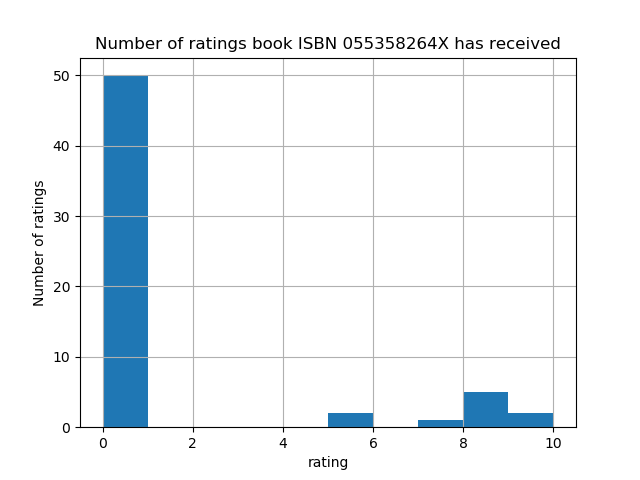

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.